# import neccesary libraries

In [63]:
from multiprocessing import freeze_support, Process, Queue, Pipe
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import time
import numpy as np
import math
import random
import matplotlib.pyplot as plt
xrange = range


# Parallel tempring for Travling salesman problem

### 1. Generate random coordinates and generate graphs

In [64]:
def generate_random_coords(num_nodes):
    return [[random.uniform(-800, 800), random.uniform(-800, 800)] for i in range(num_nodes)]


In [65]:
def generate_graph(coords):
    graph = []
    graph_fit = []

    N = len(coords)
    # holds the index of all coordinate values starting from 0 to length of the coords
    nodes = [i for i in range(N)]
    for cur_node in nodes:

        # "Inf" stores an infinite value, it acts as an unbounded upper value for comparison. This is useful for finding lowest values for something
        best_fitness = float("Inf")
        fitness_list = []

        # cur_node = random.choice(nodes)  # start from a random node
        solution = [cur_node]
        free_nodes = set(nodes)
        free_nodes.remove(cur_node)

        while free_nodes:
            # find nearest neighbour starting from current node until free node is empty
            next_node = min(
                free_nodes, key=lambda x: calculate_distance(coords, cur_node, x))
            free_nodes.remove(next_node)
            solution.append(next_node)
            cur_node = next_node

        cur_fit = fitness(coords, solution)

        graph.append(solution)
        graph_fit.append(cur_fit)
    return np.asarray(graph),  np.asarray(graph_fit)


In [66]:
def current_best(coords):
    """
    Greedy algorithm to get an initial solution (closest-neighbour).
    """
    N = len(coords)
    # holds the index of all coordinate values starting from 0 to length of the coords
    nodes = [i for i in range(N)]
    cur_node = random.choice(nodes)  # start from a random node
    solution = [cur_node]
    free_nodes = set(nodes)
    free_nodes.remove(cur_node)

    while free_nodes:
        # find nearest neighbour starting from current node until free node is empty
        next_node = min(
            free_nodes, key=lambda x: calculate_distance(coords, cur_node, x))
        free_nodes.remove(next_node)
        solution.append(next_node)
        cur_node = next_node

    return solution


In [67]:
def calculate_distance(coords, node_0, node_1):
    """
    Euclidean distance between two nodes.
    """
    coord_0, coord_1 = coords[node_0], coords[node_1]
    return math.sqrt((coord_0[0] - coord_1[0]) ** 2 + (coord_0[1] - coord_1[1]) ** 2)


In [68]:
def fitness(coords, solution):
    """
    To calculate the total distance of the weight of the route.
    """
    cur_fit = 0
    N = len(coords)
    for i in range(N):
        cur_fit += calculate_distance(coords,
                                      solution[i % N], solution[(i + 1) % N])
    return cur_fit


### 2. Parallel tempering algorithms

In [69]:
def prob(a, b):
    return np.exp(a / b)


def initialize_once(graph, function, X, T, prev_E, history, swap_function, nswaps,
                    accepted=0):
    X_star = swap_function(X, nswaps)
    new_E = function(graph, X_star)
    delta_E = new_E - prev_E

    if np.random.uniform() < prob(-delta_E, T):
        X = X_star.copy()
        accepted += 1
        prev_E = new_E

    current_time = time.time()
    history.append([prev_E, X_star, T, current_time])

    return X, prev_E, delta_E, history, accepted


def swapindex(cities):
    indices = range(len(cities))
    c1, c2 = np.random.choice(indices, 2, replace=False)
    changedCities = cities.copy()
    changedCities[c1] = cities[c2]
    changedCities[c2] = cities[c1]
    return changedCities


def distance(graph, citypath):
    distance = 0
    number_of_cities = len(citypath)
    for j in range(number_of_cities):
        if j == (number_of_cities - 1):
            distance += graph[citypath[j], citypath[0]]
        else:
            distance += graph[citypath[j], citypath[j+1]]
    return distance


def changepath(inputcities, nswaps):
    cities = inputcities.copy()
    for i in range(nswaps):
        swappedCities = swapindex(cities)
        cities = swappedCities.copy()
    return cities


def hist_best(history):
    # History as stored as a list of lists: [current distance, current path, temperature, current time]

    # Starting points to calculate the shortest path found and elapsed time at each step
    mindist = history[0][0]
    starttime = history[0][3]

    dist_hist = []
    time_hist = []

    for i in history:
        if i[0] < mindist:
            mindist = i[0]  # Update lowest value in history
        dist_hist.append(mindist)

        time_hist.append(i[3] - starttime)  # Update elapsed time

    return dist_hist, time_hist


In [70]:
def tempering(graph, function, initial_Xs, initial_temps,
              iterr, swap_function, nswaps, nbefore):
    assert(len(initial_temps) == len(initial_Xs)
           ), "Mismatched input dimensions"
    assert(initial_temps[0] == 1), "First temperature should be one"

    nsystems = len(initial_temps)
    Xs = list(initial_Xs)
    Ts = initial_temps
    prev_Es = [function(graph, Xs[i]) for i in range(nsystems)]
    delta_Es = [0] * nsystems
    history = [[] for i in xrange(nsystems)]
    best_path = []
    best_path_value = float('inf')
    current_time = time.time()

    for i in range(nsystems):
        history[i].append([prev_Es[i], initial_Xs[i], Ts[i], current_time])

    for step in range(iterr):
        for i in range(nsystems):
            Xs[i], prev_Es[i], delta_Es[i], history[i], _ =\
                initialize_once(graph, function, Xs[i], Ts[i], prev_Es[i],
                                history[i], swap_function, nswaps)
            if prev_Es[i] < best_path_value:
                best_path = Xs[i]
                best_path_value = prev_Es[i]

        if step % nbefore == 0:
            for i in range(nsystems - 1, 0, -1):
                A = np.exp(min(0, ((delta_Es[i] - delta_Es[i-1])/Ts[i]) +
                               ((delta_Es[i-1] - delta_Es[i])/Ts[i-1])))
                if np.random.uniform() < A:
                    # Exchange most recent updates and paths
                    prev_Es[i], prev_Es[i-1] = prev_Es[i-1], prev_Es[i]
                    Xs[i], Xs[i-1] = Xs[i-1], Xs[i]

    return best_path, history


In [71]:
class Timer(object):
    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.interval = self.end - self.start


### 3. Solve Travling salesman problem by Parallel Tempering

In [72]:
# Load graph

coords = generate_random_coords(150)  # read_coords("coord.txt")

graph, graph_fit = generate_graph(coords)

bestpath = current_best(coords)

# Square matrix
assert graph.shape[0] == graph.shape[1]
size = graph.shape[0]

# Square matrix
assert graph.shape[0] == graph.shape[1]
size = graph.shape[0]
optimum = distance(graph, bestpath)

# Initial values for parallel tempering
	#Initial values for parallel tempering
num_processes = 4
ratio = np.sqrt(5) #Ratio of temperatures between processes
iterr=60000
nswaps = 1
nbefore = 500
initial_temps = [ratio**i for i in range(num_processes)]

# Initial values for simulated annealing
# As hot as the hottest parallel tempering process
initial_temp = initial_temps[num_processes-1]
# Cools at a rate equal to the ratio between the PT process temperatures
cool = 1./ratio
# Reheats when it is as cold as the coldest PT process
reheat = initial_temps[0]

# Number of runs per method:
runs = 15

with Timer() as t:
    # Collect all the distances that are calculated in each run:

    time_hist_spt = []
    dist_hist_spt = []

    for i in range(runs):
        # Use the same initial paths for all algorithms
        initial_Xs = [np.random.permutation(
            size) for a in range(num_processes)]

        # Run each algorithm using the specified parameters, take their best values and elapsed times throughout the algorithm,
        #    and append these to a list for each.

        solution_spt, histories_spt = tempering(
            graph, distance, initial_Xs, initial_temps, iterr, changepath, nswaps, nbefore)
        best_hist, time_hist = hist_best(histories_spt[0])
        time_hist_spt.append(time_hist)
        dist_hist_spt.append(best_hist)
        # time_hist_spt = np.append(time_hist_spt, time_hist)
        # dist_hist_spt = np.append(dist_hist_spt, best_hist)

# Take the mean of each column, save these outputs so they can be plotted and examined without re-running simulations
dist_hist_spt = np.mean(dist_hist_spt, 0)
time_hist_spt = np.mean(time_hist_spt, 0)


### 4. Plot Travel salesman problem

In [73]:
def plot_cities(coords):
    """
    Plot the fitness through iterations.
    """
    coordinates = np.array(coords)
    plt.figure(figsize=(10, 7))
    plt.scatter(coordinates[:, 0], coordinates[:, 1], s=10)
    plt.title('150 cities')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()


In [74]:
def plot_tarvel_salesman_problem(paths, points):
    """
    path: List of lists with the different orders in which the nodes are visited
    points: coordinates for the different nodes
    num_iters: number of paths that are in the path list
    """

    # Unpack the primary Travel Salesman Problem path and transform it into a list of ordered
    # coordinates

    x = []
    y = []
    for i in paths[0]:
        x.append(points[i][0])
        y.append(points[i][1])

    plt.plot(x, y, 'co')

    # Set a scale for the arrow heads
    a_scale = float(max(x))/float(100)

    # Draw the primary path for the Travel Salesman Problem  problem
    plt.arrow(x[-1], y[-1], (x[0] - x[-1]), (y[0] - y[-1]), head_width=a_scale,
              color='g', length_includes_head=True)
    for i in range(0, len(x)-1):
        plt.arrow(x[i], y[i], (x[i+1] - x[i]), (y[i+1] - y[i]), head_width=a_scale,
                  color='g', length_includes_head=True)

    # Set axis too slitghtly larger than the set of x and y
    plt.xlim(min(x)*1.1, max(x)*1.1)
    plt.ylim(min(y)*1.1, max(y)*1.1)
    plt.show()


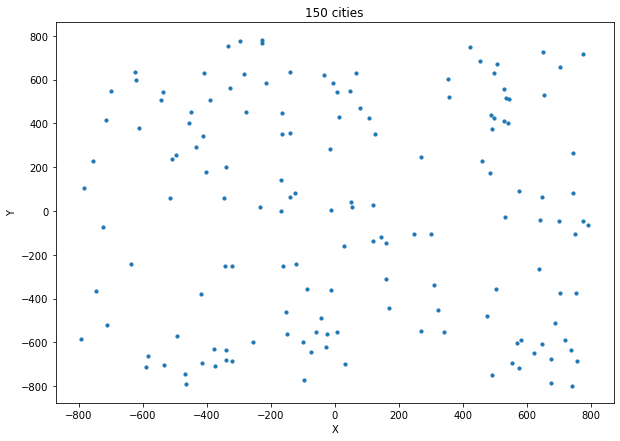

In [75]:
plot_cities(coords)


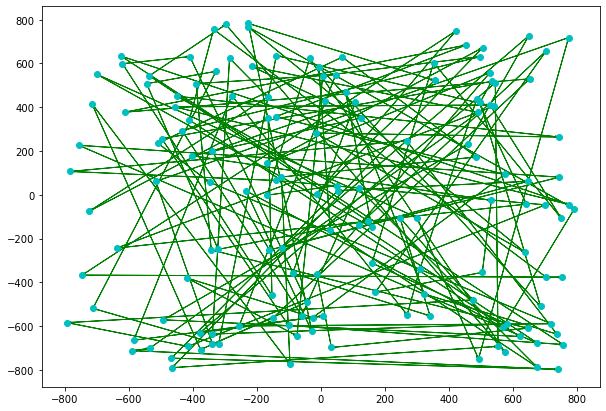

In [76]:
plt.figure(figsize=(10, 7))
plot_tarvel_salesman_problem([solution_spt], coords)


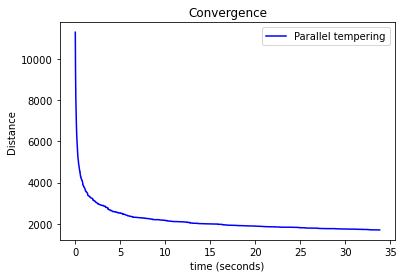

In [78]:

plt.plot(time_hist_spt, dist_hist_spt, color='b', label="Parallel tempering")


plt.legend(loc='best', prop={'size': 10})
plt.title('Convergence')
plt.ylabel('Distance')
plt.xlabel('time (seconds)')

plt.show()
